### Spatial Autocorrelation of Closed Mobile Home Parks in Carson

Author: Aurelia Mora

Here, I will be conducting a spatial autocorrelation analysis of closed mobile home parks in Carson. This information is largely drawn from the previously geocoded closed mobile home park data and American Community Survey census data. 

The intended purpose of this notebook is to provide a comparison to the spatial autocorrelation done for the currently existing mobile home parks in El Monte. We have selected both El Monte and Carson to focus on because each city was "#1" in the number of mobile home parks that currently exist/existed. 

Through this analysis, we also seek to dig deeper into the demographic (ie. population) differences within each city and begin identifying other indicators that may reveal significant differences in mobile home park proximity for residents in these cities. 

#### Importing the Libraries

In [285]:
# to read and wrangle data
import pandas as pd

# to import data from LA Data portal
from sodapy import Socrata

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

In [286]:
# city of Carson population block group data from american community survey census data
mhp_carson = gpd.read_file('data/carson_acs2019_5yr_B03002_15000US060375433222.geojson')

In [287]:
# to really illustrate the demographic and mhp data, let's bring in the census tracts for the city of Carson
mhp_tracts = gpd.read_file('data/tracts_acs2019_5yr_B03002_14000US06037544002.geojson')

<AxesSubplot:>

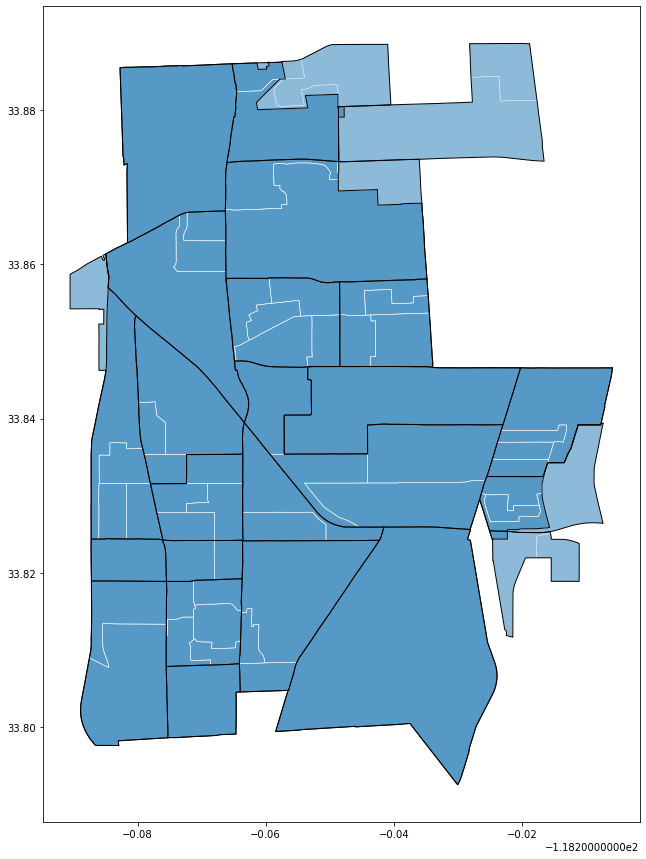

In [288]:
# let's compare!
fig,ax = plt.subplots(figsize=(15,15))

# blue represents the background (census tracts)
mhp_tracts.plot(ax=ax,zorder=10,alpha=0.5)

# while lines outline the census block groups 
mhp_carson.boundary.plot(ax=ax,color='white',zorder=15,lw=0.5)

# black boundary lines indicate where the census tracts are, on top of everything
mhp_tracts.boundary.plot(ax=ax,color='black',zorder=20,lw=1)

#### To take a zoomed in look, let's define the bounds for the city and compare

In [289]:
# total bounds
minx,miny,maxx,maxy = mhp_tracts.total_bounds

(34.092546999999996, 33.588609000000005)

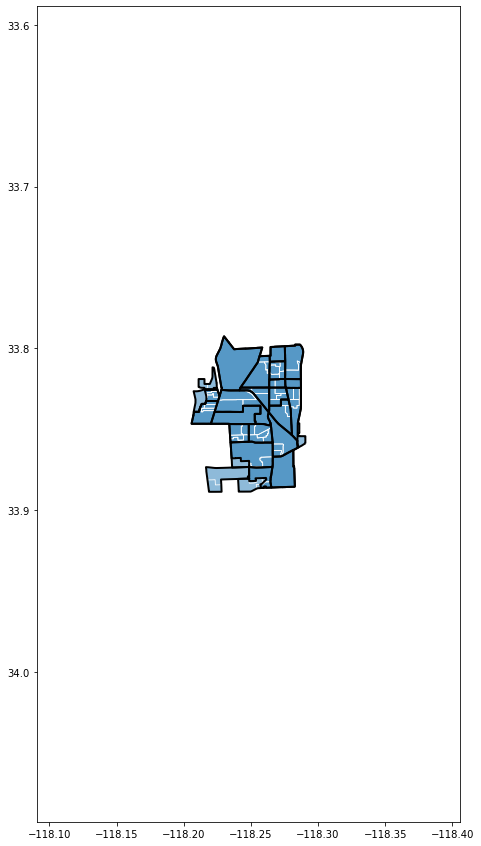

In [290]:
# compare
fig,ax = plt.subplots(figsize=(20,15))

# blue background, census tracts
mhp_tracts.plot(ax=ax,zorder=10,alpha=0.5)

# black boundary, borders of the census tracts
mhp_tracts.boundary.plot(ax=ax,color='black',zorder=20,lw=2)

# while lines show the block groups 
mhp_carson.boundary.plot(ax=ax,color='white',zorder=15,lw=0.8)

# zooming in
ax.set_xlim(minx+0.2,maxx-0.2) # zooming in just a bit
ax.set_ylim(miny+0.3,maxy-0.3)

Now that I have a general sense of what my geographic scope looks like, I want to be sure I'm understanding the data itself (ie. what are the columns? do I need to clean up my data? what will be most useful as I move forward?)

In [291]:
mhp_carson.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 45 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   geoid             60 non-null     object  
 1   name              60 non-null     object  
 2   B03002001         60 non-null     float64 
 3   B03002001, Error  60 non-null     float64 
 4   B03002002         60 non-null     float64 
 5   B03002002, Error  60 non-null     float64 
 6   B03002003         60 non-null     float64 
 7   B03002003, Error  60 non-null     float64 
 8   B03002004         60 non-null     float64 
 9   B03002004, Error  60 non-null     float64 
 10  B03002005         60 non-null     float64 
 11  B03002005, Error  60 non-null     float64 
 12  B03002006         60 non-null     float64 
 13  B03002006, Error  60 non-null     float64 
 14  B03002007         60 non-null     float64 
 15  B03002007, Error  60 non-null     float64 
 16  B03002008         60

In [292]:
mhp_carson.head()

geoid                            name  B03002001  \
0  15000US060375410021  Block Group 1, Los Angeles, CA     3318.0   
1  15000US060375431005  Block Group 5, Los Angeles, CA      757.0   
2  15000US060375431006  Block Group 6, Los Angeles, CA      839.0   
3  15000US060375432024  Block Group 4, Los Angeles, CA     1219.0   
4  15000US060375433041  Block Group 1, Los Angeles, CA     1183.0   

   B03002001, Error  B03002002  B03002002, Error  B03002003  B03002003, Error  \
0             280.0     2360.0             353.0      485.0             166.0   
1             411.0      610.0             396.0        0.0              12.0   
2             304.0      799.0             293.0        0.0              12.0   
3             447.0      129.0             111.0        0.0              12.0   
4             385.0     1164.0             390.0      337.0             262.0   

   B03002004  B03002004, Error  ...  B03002017, Error  B03002018  \
0     1828.0             358.0  ...              12.0      470.0   
1      610.0             396.0  ...              12.0       84.0   
2      765.0             298.0  ...              12.0        0.0   
3      129.0             111.0  ...              12.0      662.0   
4      707.0             257.0  ...              12.0       19.0   

   B03002018, Error  B03002019  B03002019, Error  B03002020  B03002020, Error  \
0             184.0        0.0              12.0        0.0              12.0   
1             101.0        0.0              12.0        0.0              12.0   
2              12.0        0.0              12.0        0.0              12.0   
3             398.0        0.0              12.0        0.0              12.0   
4              32.0        0.0              12.0        0.0              12.0   

   B03002021  B03002021, Error  \
0        0.0              12.0   
1        0.0              12.0   
2        0.0              12.0   
3        0.0              12.0   
4        0.0              12.0   

                                            geometry  
0  MULTIPOLYGON (((-118.28273 33.88547, -118.2826...  
1  MULTIPOLYGON (((-118.26600 33.87342, -118.2659...  
2  MULTIPOLYGON (((-118.26523 33.88598, -118.2637...  
3  MULTIPOLYGON (((-118.24866 33.88042, -118.2482...  
4  MULTIPOLYGON (((-118.24459 33.85660, -118.2437...  

[5 rows x 45 columns]

#### Cleaning up the Data

In [293]:
# trim the data to the bare minimum columns
mhp_carson = mhp_carson[['geoid','B03002001','geometry']]

# rename the columns
mhp_carson.columns = ['FIPS','TotalPop','geometry']

In [294]:
mhp_carson.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FIPS      60 non-null     object  
 1   TotalPop  60 non-null     float64 
 2   geometry  60 non-null     geometry
dtypes: float64(1), geometry(1), object(1)
memory usage: 1.5+ KB


In [295]:
mhp_carson.head()

FIPS  TotalPop  \
0  15000US060375410021    3318.0   
1  15000US060375431005     757.0   
2  15000US060375431006     839.0   
3  15000US060375432024    1219.0   
4  15000US060375433041    1183.0   

                                            geometry  
0  MULTIPOLYGON (((-118.28273 33.88547, -118.2826...  
1  MULTIPOLYGON (((-118.26600 33.87342, -118.2659...  
2  MULTIPOLYGON (((-118.26523 33.88598, -118.2637...  
3  MULTIPOLYGON (((-118.24866 33.88042, -118.2482...  
4  MULTIPOLYGON (((-118.24459 33.85660, -118.2437...

In [296]:
mhp_carson.tail()

FIPS  TotalPop  \
55  15000US060375440023    1103.0   
56  15000US060375723012    1755.0   
57  15000US060379800021       0.0   
58  15000US060379800251       0.0   
59       16000US0611530   92079.0   

                                             geometry  
55  MULTIPOLYGON (((-118.22588 33.82930, -118.2258...  
56  MULTIPOLYGON (((-118.22509 33.82548, -118.2237...  
57  MULTIPOLYGON (((-118.25753 33.80197, -118.2571...  
58  MULTIPOLYGON (((-118.25712 33.83927, -118.2571...  
59  MULTIPOLYGON (((-118.28888 33.80246, -118.2888...

In [297]:
# I'm going to delete the last row since it represents the city of Carson itself
mhp_carson = mhp_carson.drop(59)

In [298]:
mhp_carson.tail()

FIPS  TotalPop  \
54  15000US060375440022    1476.0   
55  15000US060375440023    1103.0   
56  15000US060375723012    1755.0   
57  15000US060379800021       0.0   
58  15000US060379800251       0.0   

                                             geometry  
54  MULTIPOLYGON (((-118.22604 33.83122, -118.2258...  
55  MULTIPOLYGON (((-118.22588 33.82930, -118.2258...  
56  MULTIPOLYGON (((-118.22509 33.82548, -118.2237...  
57  MULTIPOLYGON (((-118.25753 33.80197, -118.2571...  
58  MULTIPOLYGON (((-118.25712 33.83927, -118.2571...

In [299]:
# fixing the FIPS code
mhp_carson['FIPS'] = mhp_carson['FIPS'].str.replace('15000US','')
mhp_carson.tail()

FIPS  TotalPop                                           geometry
54  060375440022    1476.0  MULTIPOLYGON (((-118.22604 33.83122, -118.2258...
55  060375440023    1103.0  MULTIPOLYGON (((-118.22588 33.82930, -118.2258...
56  060375723012    1755.0  MULTIPOLYGON (((-118.22509 33.82548, -118.2237...
57  060379800021       0.0  MULTIPOLYGON (((-118.25753 33.80197, -118.2571...
58  060379800251       0.0  MULTIPOLYGON (((-118.25712 33.83927, -118.2571...

In [300]:
# sorting by the total population
mhp_carson.sort_values(by='TotalPop').head(20)

FIPS  TotalPop                                           geometry
58  060379800251       0.0  MULTIPOLYGON (((-118.25712 33.83927, -118.2571...
57  060379800021       0.0  MULTIPOLYGON (((-118.25753 33.80197, -118.2571...
17  060375433224     414.0  MULTIPOLYGON (((-118.25360 33.84798, -118.2527...
10  060375433063     474.0  MULTIPOLYGON (((-118.26487 33.84746, -118.2646...
21  060375434003     532.0  MULTIPOLYGON (((-118.28494 33.86134, -118.2849...
49  060375440011     570.0  MULTIPOLYGON (((-118.22299 33.83919, -118.2225...
53  060375440021     608.0  MULTIPOLYGON (((-118.22662 33.82955, -118.2263...
46  060375439051     632.0  MULTIPOLYGON (((-118.26381 33.81625, -118.2637...
35  060375437025     736.0  MULTIPOLYGON (((-118.27549 33.81246, -118.2754...
1   060375431005     757.0  MULTIPOLYGON (((-118.26600 33.87342, -118.2659...
33  060375437023     798.0  MULTIPOLYGON (((-118.27194 33.81091, -118.2718...
2   060375431006     839.0  MULTIPOLYGON (((-118.26523 33.88598, -118.2637...
39  060375438013     871.0  MULTIPOLYGON (((-118.27896 33.83533, -118.2779...
41  060375438022     881.0  MULTIPOLYGON (((-118.27791 33.83156, -118.2749...
9   060375433062     946.0  MULTIPOLYGON (((-118.24412 33.83872, -118.2441...
14  060375433221    1059.0  MULTIPOLYGON (((-118.25948 33.85822, -118.2585...
55  060375440023    1103.0  MULTIPOLYGON (((-118.22588 33.82930, -118.2258...
22  060375435011    1111.0  MULTIPOLYGON (((-118.29052 33.85870, -118.2897...
50  060375440012    1118.0  MULTIPOLYGON (((-118.22549 33.83251, -118.2251...
51  060375440013    1148.0  MULTIPOLYGON (((-118.22355 33.83770, -118.2232...

#### Working with (and mapping) the census blocks 

In [301]:
# before mapping, I want to delete the rows with less than 100 population geographies
mhp_carson = mhp_carson[mhp_carson['TotalPop']>100]

In [302]:
# lets get these layers into a web mercator projection
# reproject to web mercator
mhp_carson = mhp_carson.to_crs(epsg=3857)

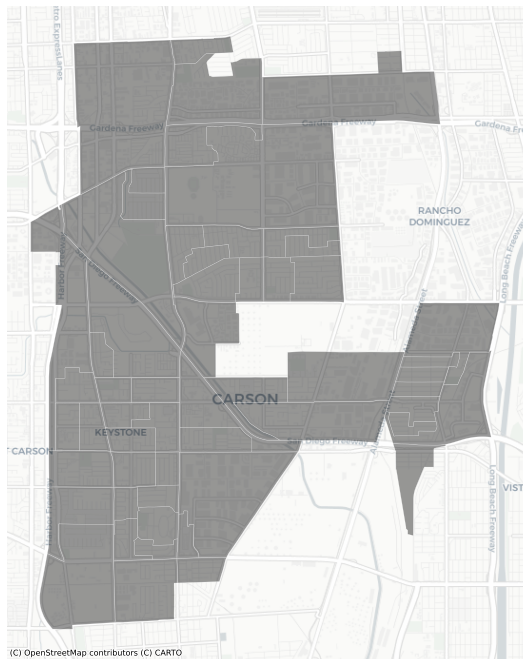

In [303]:
# lets plot it!
fig, ax = plt.subplots(figsize=(12,12))

mhp_carson.plot(ax=ax,
         color='black', 
         edgecolor='white',
         lw=0.5,
         alpha=0.4)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

#### Bringing in my geocoded data for closed mobile home parks in LA County

This is (what I believe to be) the core of my analysis, and the focus of this project overall. Now I can map the data I had with my census demographics and block group data.

In [304]:
closedmhp = gpd.read_file('data/closedmhps_geocoded.geojson')

In [305]:
closedmhp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Park Name           59 non-null     object  
 1   County              59 non-null     object  
 2   Park Identifier     59 non-null     object  
 3   Park Address        59 non-null     object  
 4   city                59 non-null     object  
 5   zipcode             59 non-null     int64   
 6   phone number        49 non-null     object  
 7   Fire Authority      59 non-null     object  
 8   Jurisdiction        59 non-null     object  
 9   MH Spaces           51 non-null     float64 
 10  RV Lots W/Drains    51 non-null     float64 
 11  RV Lots W/O Drains  51 non-null     float64 
 12  Operated by         50 non-null     object  
 13  lat                 59 non-null     float64 
 14  lon                 59 non-null     float64 
 15  geometry            59 non-null   

In [306]:
closedmhp['city'].value_counts()

 CARSON             6
 EL MONTE           5
 LOS ANGELES        5
 BALDWIN PARK       3
 GLENDALE           3
 INGLEWOOD          3
 ROSEMEAD           3
 SANTA CLARITA      2
 ACTON              2
 S EL MONTE         2
 POMONA             2
 DUARTE             2
 PICO RIVERA        2
 GARDENA            1
 WILMINGTON         1
 PASADENA           1
 MONTEREY PARK      1
 AGUA DULCE         1
 BURBANK            1
 SAN DIMAS          1
 HARBOR CITY        1
 HUNTINGTON PARK    1
 GLENDORA           1
 DOWNEY             1
 PARAMOUNT          1
 CASTAIC            1
 LAKE HUGHES        1
 SANTA MONICA       1
 LYNWOOD            1
 LAWNDALE           1
 BELLFLOWER         1
 AZUSA              1
Name: city, dtype: int64

I previously created a new definition totaling the number of spaces/units that each closed mobile home park contained. I want to do that again here. 

In [307]:
closedmhps['total_unitspaces'] = closedmhps['MH Spaces'] + closedmhps['RV Lots W/Drains'] + closedmhps['RV Lots W/O Drains']

In [308]:
closedmhps['total_unitspaces'].head()

0    21.0
1    15.0
2    16.0
3    14.0
4    11.0
Name: total_unitspaces, dtype: float64

In [309]:
closedmhps.head()

Park Name       County Park Identifier  \
0   ALLGEYER PARK  LOS ANGELES      19-0005-MP   
1      GUILLEN TP  LOS ANGELES      19-0025-MP   
2      RES MOR TP  LOS ANGELES      19-0056-MP   
3    BLUE BIRD TP  LOS ANGELES      19-0067-MP   
4  BLUE BONNET TP  LOS ANGELES      19-0068-MP   

                                   Park Address           city  zipcode  \
0              2920 ALLGEYER,  EL MONTE , 91733       EL MONTE    91733   
1          1240 NADEAU ST,  LOS ANGELES , 90001    LOS ANGELES    90001   
2       13651 GARVEY AVE,  BALDWIN PARK , 91706   BALDWIN PARK    91706   
3      8827 E ARTESIA BLVD,  BELLFLOWER , 90706     BELLFLOWER    90706   
4  4432 MANHATTAN BEACH BLVD,  LAWNDALE , 90260       LAWNDALE    90260   

      phone number                                     Fire Authority  \
0   (310) 676-0663  COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...   
1   (213) 585-8828  HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...   
2   (310) 920-8148                                         null, null   
3   (310) 633-2955  COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...   
4   (310) 545-7498  COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...   

                                        Jurisdiction  MH Spaces  \
0  HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...       21.0   
1  HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...       15.0   
2  HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...       16.0   
3  HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...       11.0   
4  HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...       11.0   

   RV Lots W/Drains  RV Lots W/O Drains  \
0               0.0                 0.0   
1               0.0                 0.0   
2               0.0                 0.0   
3               0.0                 3.0   
4               0.0                 0.0   

                                         Operated by        lat         lon  \
0  FRANK, DORIS, 2239 PARKWAY DR #7, EL MONTE, CA...  34.059780 -118.018559   
1  GUILLEN, JOSE, C/O GUILLEN TRAILER PARK 1240 N...  33.967385 -118.253825   
2  LEE WAYNE & CO, 15865B GALE AVE SUITE # 428, C...  34.069674 -117.971467   
3  BOGGS, VIRGINIA, PO BOX 787, BELLFLOWER, CA 90706  33.874661 -118.151442   
4  LAWNDALE REDEVELOPMENT AGENCY, 14717 BURIN AVE...  33.887247 -118.353424   

                            geometry  total_unitspaces  
0  POINT (-13137765.868 4036831.838)              21.0  
1  POINT (-13163955.552 4024423.480)              15.0  
2  POINT (-13132523.668 4038161.424)              16.0  
3  POINT (-13152558.338 4011984.505)              14.0  
4  POINT (-13175042.942 4013672.115)              11.0

While this "total" definition is helpful, my focus is on the city of Carson. So I want to create a specific definition to narrow down my data to the city of Carson.

In [310]:
carson = closedmhp.city.value_counts().head(1).index.tolist()

In [311]:
carson

[' CARSON']

In [312]:
carsoncity = closedmhp[closedmhp['city']== ' CARSON']
carsoncity.shape

(6, 16)

In [313]:
carsoncity.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 6 entries, 15 to 57
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Park Name           6 non-null      object  
 1   County              6 non-null      object  
 2   Park Identifier     6 non-null      object  
 3   Park Address        6 non-null      object  
 4   city                6 non-null      object  
 5   zipcode             6 non-null      int64   
 6   phone number        6 non-null      object  
 7   Fire Authority      6 non-null      object  
 8   Jurisdiction        6 non-null      object  
 9   MH Spaces           6 non-null      float64 
 10  RV Lots W/Drains    6 non-null      float64 
 11  RV Lots W/O Drains  6 non-null      float64 
 12  Operated by         6 non-null      object  
 13  lat                 6 non-null      float64 
 14  lon                 6 non-null      float64 
 15  geometry            6 non-null    

In [314]:
carsoncity.head()

Park Name       County Park Identifier  \
15  MACKS TRAILER LODGE  LOS ANGELES      19-0390-MP   
22        SHADY NOOK TP  LOS ANGELES      19-0635-MP   
42        BEL ABBEY MHP  LOS ANGELES      19-1234-MP   
43         DOMINGUEZ TP  LOS ANGELES      19-1311-MP   
46       LITTLE DUDE TP  LOS ANGELES      19-1327-MP   

                            Park Address     city  zipcode     phone number  \
15  17524 S FIGUEROA ST,  CARSON , 90745   CARSON    90745   (213) 323-2312   
22   21009 PROSPECT AVE,  CARSON , 90810   CARSON    90810   (818) 442-0383   
42   200 E GARDENA BLVD,  CARSON , 90745   CARSON    90745   (310) 323-3073   
43    2666 DOMINGUEZ ST,  CARSON , 90810   CARSON    90810   (310) 679-2077   
46       630 E 220TH ST,  CARSON , 90745   CARSON    90745   (909) 595-8635   

                                       Fire Authority  \
15                                         null, null   
22  COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...   
42  COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...   
43  COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...   
46  COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...   

                                         Jurisdiction  MH Spaces  \
15  HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...       47.0   
22  HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...        6.0   
42  HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...       50.0   
43  HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...       31.0   
46  HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...       12.0   

    RV Lots W/Drains  RV Lots W/O Drains  \
15               0.0                 0.0   
22               0.0                 0.0   
42               0.0                 0.0   
43               0.0                 0.0   
46               0.0                 0.0   

                                          Operated by        lat         lon  \
15  BUCKLES, ROBERT, 1483 ALLENFORD AVE, LOS ANGEL...  33.845406 -118.284245   
22   CARLSEN, KENT, PO BOX 8321, LONG BEACH, CA 90808  33.839029 -118.218364   
42  HAPPY TRAILS, 334 GARDENA BLV., GARDENA, CA 90248  33.882030 -118.273250   
43  CITY OF CARSON, CA, 1 CIVIC PLAZA, #500, LONG ...  33.839110 -118.219237   
46    SHIMIZU, SIG, 630 E 220TH ST., CARSON, CA 90746  33.827767 -118.264843   

                             geometry  
15  POINT (-13167341.878 4008062.697)  
22  POINT (-13160008.111 4007207.968)  
42  POINT (-13166117.964 4012972.516)  
43  POINT (-13160105.265 4007218.835)  
46  POINT (-13165182.139 4005698.699)

#### Converting my data to a Geodataframe

This will allow me to convert my data into a spatial format and thus create a spatial analysis.

In [315]:
# convert pandas dataframe to geodataframe
carsoncity = gpd.GeoDataFrame(carsoncity, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(carsoncity.lon, carsoncity.lat))

In [316]:
# get the layers into a web mercator projection
# reproject to web mercator
carsoncity = carsoncity.to_crs(epsg=3857)

In [317]:
# convert lat/lon to floats
carsoncity.lon = carsoncity.lon.astype('float')
carsoncity.lat = carsoncity.lat.astype('float')

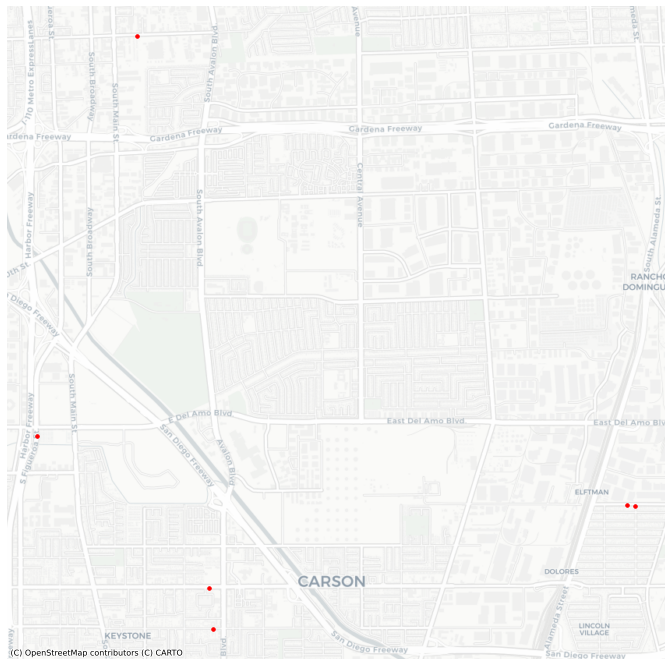

In [318]:
# map it!
fig,ax = plt.subplots(figsize=(12,12))

carsoncity.plot(ax=ax,
             color='red',
             markersize=12)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

These red dots indicate the location of the mobile home parks in the city of Carson. Now that I have this, I want to create a two-layered map to create some more context as to the location of these parks within my census block groups.

#### Creating a two-layered map

In [319]:
# get the bounding box coordinates for the arrest data
minx, miny, maxx, maxy = carsoncity.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-13167341.877739018
-13160008.110867925
4005698.699315378
4012972.5156044518


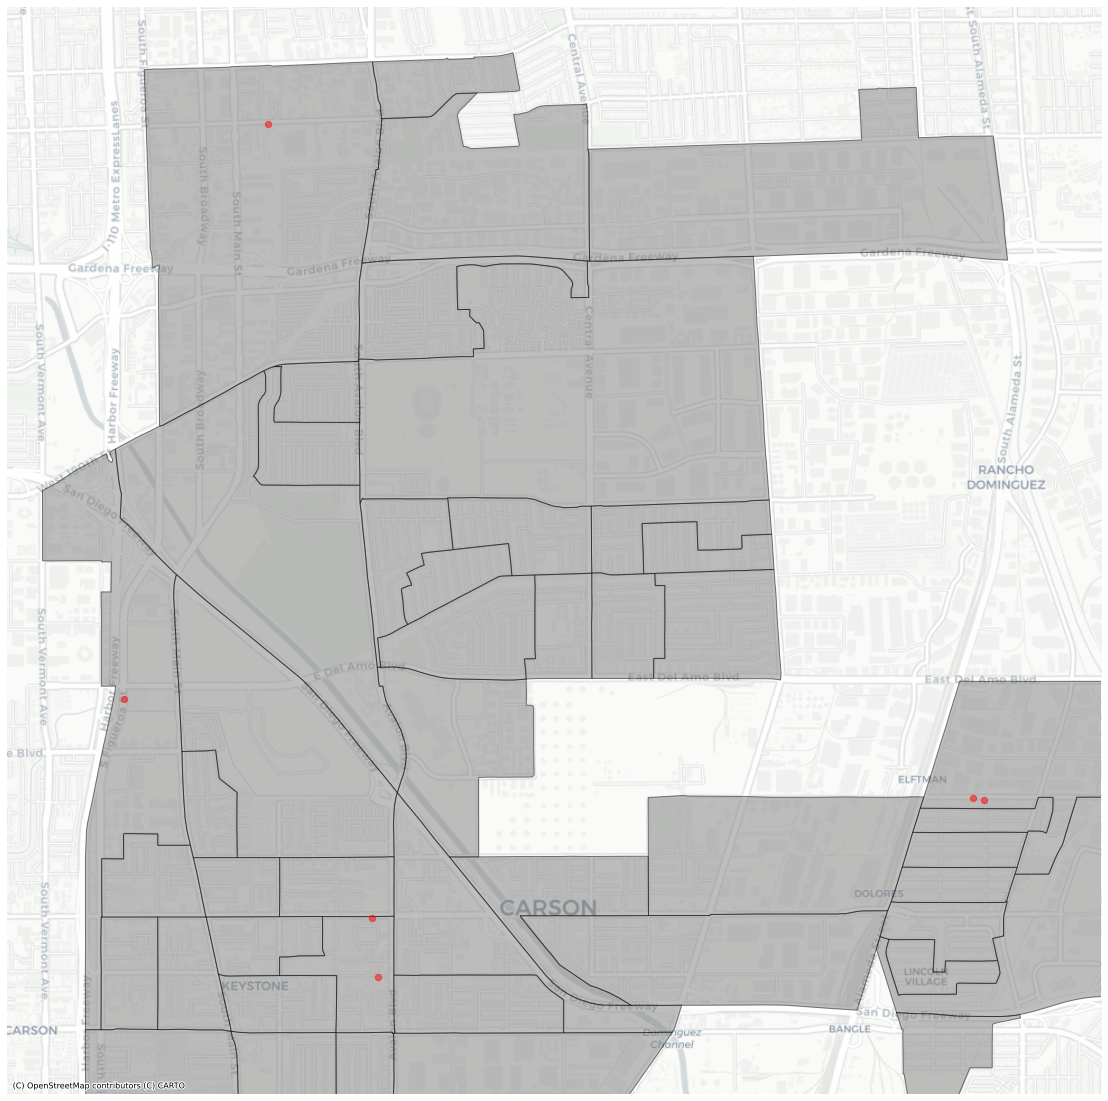

In [320]:
# set up the plot canvas with plt.subplots
fig, ax = plt.subplots(figsize=(20, 20))

# block groups
mhp_carson.plot(ax=ax, # this puts it in the ax plot
        color='gray', 
        edgecolor='black',
        alpha=0.5)

# number of mhp parks in carson
carsoncity.plot(ax=ax, # this also puts it in the same ax plot
            color='red',
            markersize=40,
            alpha=0.5)

# use the bounding box coordinates to set the x and y limits
ax.set_xlim(minx - 1000, maxx + 1000) # added/substracted value is to give some margin around total bounds
ax.set_ylim(miny - 1000, maxy + 1000)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

#### Spatial Join

Creating a spatial join will allow me to "count" the number of mhp spaces/units within each park in Carson

In [321]:
# Do the spatial join
carson_join = gpd.sjoin(carsoncity, mhp_carson, how='left')

In [322]:
carson_join.head()

Park Name       County Park Identifier  \
15  MACKS TRAILER LODGE  LOS ANGELES      19-0390-MP   
22        SHADY NOOK TP  LOS ANGELES      19-0635-MP   
42        BEL ABBEY MHP  LOS ANGELES      19-1234-MP   
43         DOMINGUEZ TP  LOS ANGELES      19-1311-MP   
46       LITTLE DUDE TP  LOS ANGELES      19-1327-MP   

                            Park Address     city  zipcode     phone number  \
15  17524 S FIGUEROA ST,  CARSON , 90745   CARSON    90745   (213) 323-2312   
22   21009 PROSPECT AVE,  CARSON , 90810   CARSON    90810   (818) 442-0383   
42   200 E GARDENA BLVD,  CARSON , 90745   CARSON    90745   (310) 323-3073   
43    2666 DOMINGUEZ ST,  CARSON , 90810   CARSON    90810   (310) 679-2077   
46       630 E 220TH ST,  CARSON , 90745   CARSON    90745   (909) 595-8635   

                                       Fire Authority  \
15                                         null, null   
22  COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...   
42  COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...   
43  COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...   
46  COUNTY OF LOS ANGELES, 5823 RICKENBACKER RD., ...   

                                         Jurisdiction  MH Spaces  \
15  HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...       47.0   
22  HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...        6.0   
42  HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...       50.0   
43  HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...       31.0   
46  HCD - SOUTHERN AREA OFFICE, 3737 MAIN ST 400, ...       12.0   

    RV Lots W/Drains  RV Lots W/O Drains  \
15               0.0                 0.0   
22               0.0                 0.0   
42               0.0                 0.0   
43               0.0                 0.0   
46               0.0                 0.0   

                                          Operated by        lat         lon  \
15  BUCKLES, ROBERT, 1483 ALLENFORD AVE, LOS ANGEL...  33.845406 -118.284245   
22   CARLSEN, KENT, PO BOX 8321, LONG BEACH, CA 90808  33.839029 -118.218364   
42  HAPPY TRAILS, 334 GARDENA BLV., GARDENA, CA 90248  33.882030 -118.273250   
43  CITY OF CARSON, CA, 1 CIVIC PLAZA, #500, LONG ...  33.839110 -118.219237   
46    SHIMIZU, SIG, 630 E 220TH ST., CARSON, CA 90746  33.827767 -118.264843   

                             geometry  index_right          FIPS  TotalPop  
15  POINT (-13167341.878 4008062.697)           22  060375435011    1111.0  
22  POINT (-13160008.111 4007207.968)           49  060375440011     570.0  
42  POINT (-13166117.964 4012972.516)            0  060375410021    3318.0  
43  POINT (-13160105.265 4007218.835)           49  060375440011     570.0  
46  POINT (-13165182.139 4005698.699)           43  060375438024    2001.0

This creates a dataframe that records the number of spaces/units with the corresponding FIPS code. Now, I want to create another dataframe that counts this same number of spaces/units by their corresponding block group.

In [323]:
mhp_by_gdf = carson_join.FIPS.value_counts().rename_axis('FIPS').reset_index(name='MH SPACES')

In [324]:
mhp_by_gdf.head()

FIPS  MH SPACES
0  060375440011          2
1  060375438024          2
2  060375435011          1
3  060375410021          1

<AxesSubplot:xlabel='FIPS'>

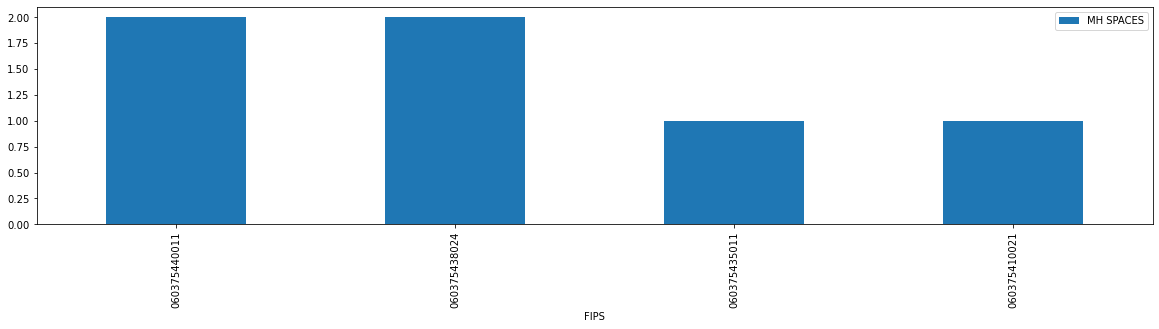

In [325]:
# make a bar chart of top 10 parks
mhp_by_gdf[:10].plot.bar(figsize=(20,4),
                             x='FIPS',
                             y='MH SPACES')

So it looks like I really only have 4 top parks since the number of parks of Carson is actually only 6...
While this information is useful, it still doesn't tell me much. A spatial map will make it easier to understand the distribution/location of these parks and how densely populated the surrounding area may be.

In [326]:
# join the summary table back to the gdf to create a new column for MH Spaces
mhp_carson = mhp_carson.merge(mhp_by_gdf,on='FIPS')

In [327]:
mhp_carson.head()

FIPS  TotalPop                                           geometry  \
0  060375410021    3318.0  MULTIPOLYGON (((-13167173.162 4013433.257, -13...   
1  060375435011    1111.0  MULTIPOLYGON (((-13168040.786 4009844.498, -13...   
2  060375438024    2001.0  MULTIPOLYGON (((-13166018.334 4005859.662, -13...   
3  060375440011     570.0  MULTIPOLYGON (((-13160522.936 4007229.825, -13...   

   MH SPACES  
0          1  
1          1  
2          2  
3          2

#### Normalizing the Data

Instead of using the raw number of MH spaces, I want to normalize it according to the number of people who live in the highlighted census block groups. I will be normalizing the data by focusing on the number of MH spaces per 1000 people. 

In [328]:
mhp_carson['mhp_per_1000'] = mhp_carson['MH SPACES']/mhp_carson['TotalPop']*1000

In [329]:
mhp_carson.sort_values(by='mhp_per_1000').tail()

FIPS  TotalPop                                           geometry  \
0  060375410021    3318.0  MULTIPOLYGON (((-13167173.162 4013433.257, -13...   
1  060375435011    1111.0  MULTIPOLYGON (((-13168040.786 4009844.498, -13...   
2  060375438024    2001.0  MULTIPOLYGON (((-13166018.334 4005859.662, -13...   
3  060375440011     570.0  MULTIPOLYGON (((-13160522.936 4007229.825, -13...   

   MH SPACES  mhp_per_1000  
0          1      0.301386  
1          1      0.900090  
2          2      0.999500  
3          2      3.508772

The below command will allow me to map the top geographies in the city.

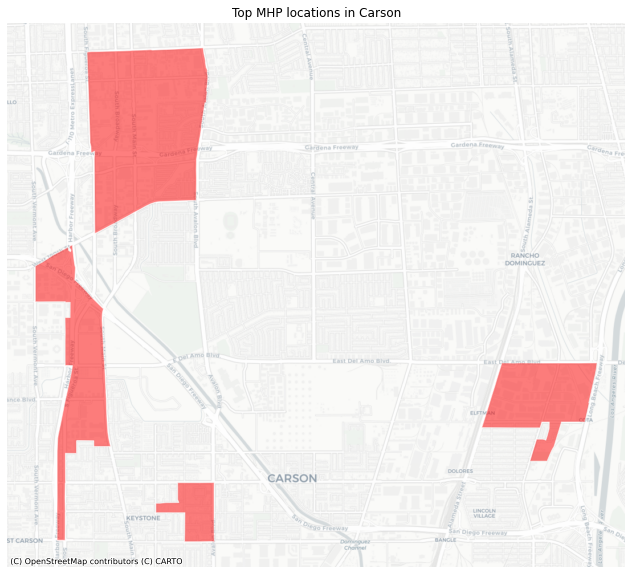

In [330]:
# map the top geographies
fig,ax = plt.subplots(figsize=(12,10))
mhp_carson.sort_values(by='mhp_per_1000',ascending=False)[:10].plot(ax=ax,
                                                                 color='red',
                                                                 edgecolor='white',
                                                                 alpha=0.5,legend=True)


# title
ax.set_title('Top MHP locations in Carson')

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

#### Choropeth Map

This choropeth map builds on the previous one by providing a more detailed visual of how densely populated the top geographies with closed mobile home parks are, thus beginning to reveal more visual information about their location which may support our interest in exploring zoning data as we move along with this project.

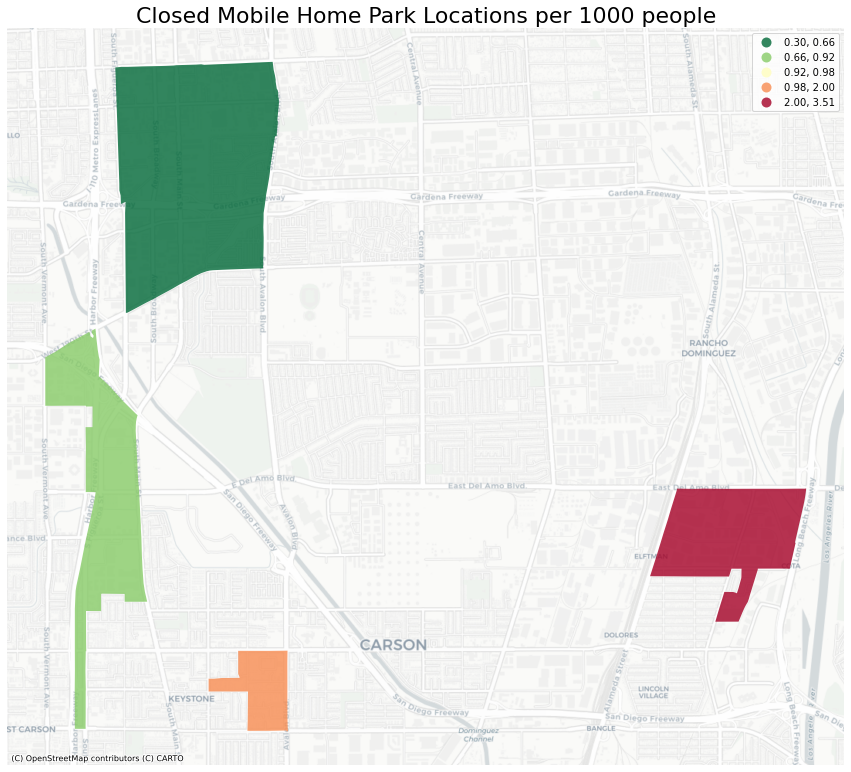

In [331]:
fig,ax = plt.subplots(figsize=(15,15))

mhp_carson.plot(ax=ax,
        column='mhp_per_1000',
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r',
        scheme='quantiles')

ax.axis('off')
ax.set_title('Closed Mobile Home Park Locations per 1000 people',fontsize=22)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

#### Spatial Autocorrelation

In [332]:
# calculate spatial weight
wq = lps.weights.KNN.from_dataframe(mhp_carson, k=3)

# Row-standardization
wq.transform = 'r'

#### Spatial Lag

In [333]:
# create a new column for the spatial lag
mhp_carson['mhp_per_1000_lag'] = lps.weights.lag_spatial(wq, mhp_carson['mhp_per_1000'])

In [334]:
mhp_carson.sample(3)[['FIPS','TotalPop','MH SPACES','mhp_per_1000','mhp_per_1000_lag']]

FIPS  TotalPop  MH SPACES  mhp_per_1000  mhp_per_1000_lag
2  060375438024    2001.0          2      0.999500          1.570083
1  060375435011    1111.0          1      0.900090          1.603220
3  060375440011     570.0          2      3.508772          0.733659

#### "The Donut" and "The Diamond"

This mapping exercise will tell me more about the surrounding areas in Carson and how their population density in relation to MH spaces/closed mobile home parks differs. More specifically, I seek to see whether the areas that are identified may have different demographic information once I begin examining zoning data, racial, and economic data.

In [335]:
# create a column that calculates the difference betwen mobile homes and lag
mhp_carson['mhp_lag_diff'] = mhp_carson['mhp_per_1000'] - mhp_carson['mhp_per_1000_lag']

In [336]:
# output to get the head and tail
mhp_carson.sort_values(by='mhp_lag_diff')

FIPS  TotalPop                                           geometry  \
0  060375410021    3318.0  MULTIPOLYGON (((-13167173.162 4013433.257, -13...   
1  060375435011    1111.0  MULTIPOLYGON (((-13168040.786 4009844.498, -13...   
2  060375438024    2001.0  MULTIPOLYGON (((-13166018.334 4005859.662, -13...   
3  060375440011     570.0  MULTIPOLYGON (((-13160522.936 4007229.825, -13...   

   MH SPACES  mhp_per_1000  mhp_per_1000_lag  mhp_lag_diff  
0          1      0.301386          1.802787     -1.501401  
1          1      0.900090          1.603220     -0.703130  
2          2      0.999500          1.570083     -0.570583  
3          2      3.508772          0.733659      2.775113

In [337]:
# the FIPS with highest negative difference
mhp_carson_donut = mhp_carson.sort_values(by='mhp_lag_diff').head(1)

In [338]:
mhp_carson_donut

FIPS  TotalPop                                           geometry  \
0  060375410021    3318.0  MULTIPOLYGON (((-13167173.162 4013433.257, -13...   

   MH SPACES  mhp_per_1000  mhp_per_1000_lag  mhp_lag_diff  
0          1      0.301386          1.802787     -1.501401

In [339]:
# the FIPS with highest positive difference
mhp_carson_diamond = mhp_carson.sort_values(by='mhp_lag_diff').tail(1)
mhp_carson_diamond

FIPS  TotalPop                                           geometry  \
3  060375440011     570.0  MULTIPOLYGON (((-13160522.936 4007229.825, -13...   

   MH SPACES  mhp_per_1000  mhp_per_1000_lag  mhp_lag_diff  
3          2      3.508772          0.733659      2.775113

In [360]:
# set the mapbox access token
token = 'sk.eyJ1IjoiYXVyZWxpYW1jMTk5NiIsImEiOiJja3dkODBidjM0ZzIxMnVsdGYzZGdwdDJkIn0.OiISmc6UtaE_-r7W9cJ1rg'
px.set_mapbox_access_token(token)

In [361]:
# subset donut, project to WGS84, and get its centroid
mhp_carson_donut = mhp_carson_donut.to_crs('epsg:4326')

# what's the centroid?
minx, miny, maxx, maxy = mhp_carson_donut.geometry.total_bounds
center_lat_donut = (maxy-miny)/2+miny
center_lon_donut = (maxx-minx)/2+minx

In [362]:
# subset diamond, project to WGS84, and get its centroid
mhp_carson_diamond = mhp_carson_diamond.to_crs('epsg:4326')

# what's the centroid?
minx, miny, maxx, maxy = mhp_carson_diamond.geometry.total_bounds
center_lat_diamond = (maxy-miny)/2+miny
center_lon_diamond = (maxx-minx)/2+minx

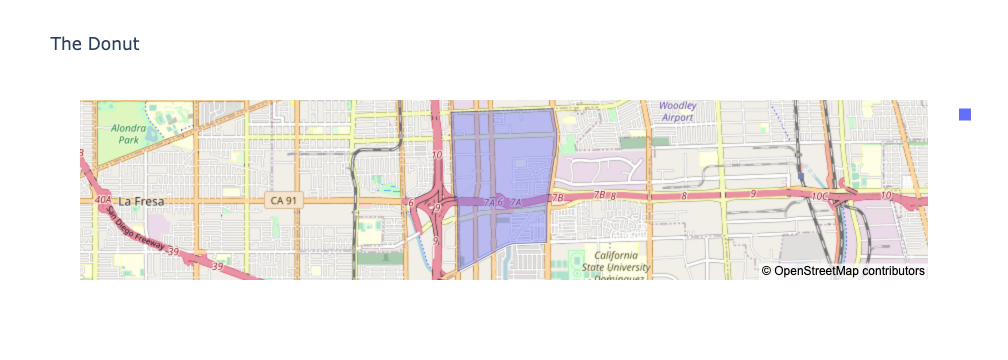

In [363]:
px.choropleth_mapbox(mhp_carson_donut, 
                     geojson = mhp_carson_donut.geometry, 
                     locations = mhp_carson_donut.index, 
                     mapbox_style = "open-street-map",
                     zoom=12, 
                     center = {"lat": center_lat_donut, "lon": center_lon_donut},
                     hover_data=['FIPS','TotalPop','MH SPACES','mhp_per_1000','mhp_per_1000_lag'],
                     opacity=0.4,
                     title='The Donut')

This community north of Carson is my "donut", indicating that the surrounding area may be more densely populated and have a higher number of closed mobile home parks and mobile home park spaces. 

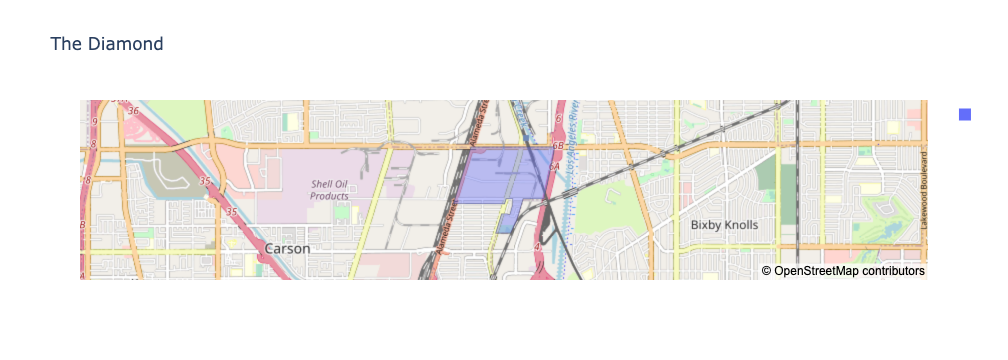

In [344]:
px.choropleth_mapbox(mhp_carson_diamond, 
                     geojson=mhp_carson_diamond.geometry, 
                     locations=mhp_carson_diamond.index, 
                     mapbox_style="open-street-map",
                     zoom=12, 
                     center = {"lat": center_lat_diamond, "lon": center_lon_diamond},
                     hover_data=['FIPS','TotalPop','MH SPACES','mhp_per_1000','mhp_per_1000_lag'],
                     opacity=0.4,
                     title='The Diamond')

This area to the NE of Carson is "the diamond". This area has a higher number of closed mobile home parks/mobile home park spaces per 1000 residents than the surrounding areas. 

#### Spatial Lag Map

Mapping my dataframe with the spatial lag column

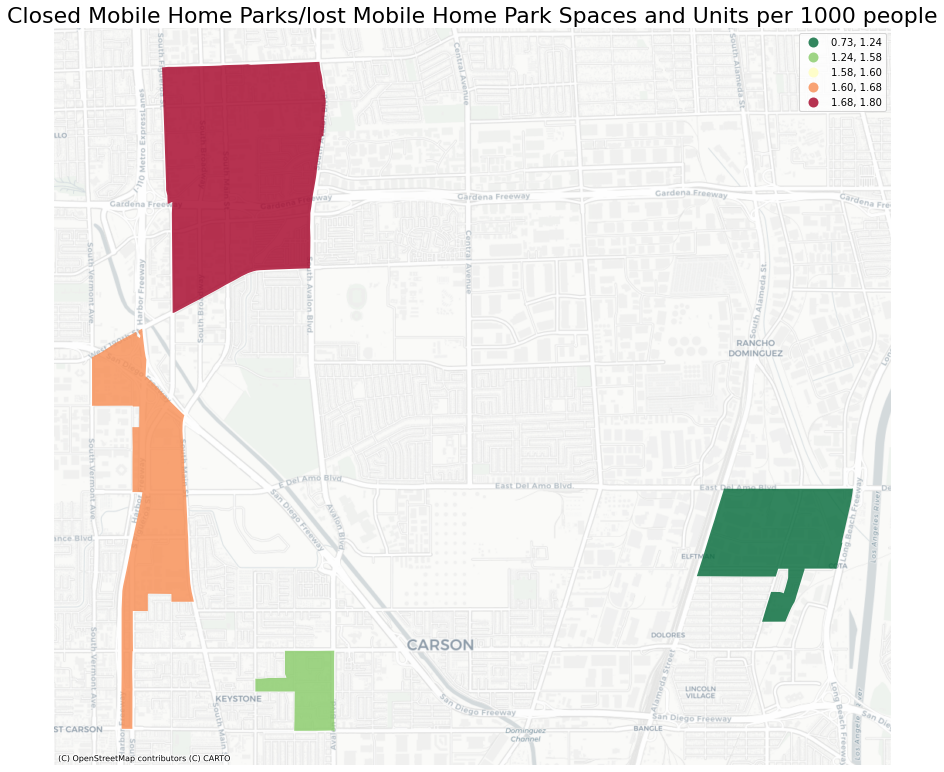

In [345]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(15, 15))

# spatial lag choropleth
mhp_carson.plot(ax=ax,
         figsize=(15,15),
         column='mhp_per_1000_lag',
         legend=True,
         alpha=0.8,
         cmap='RdYlGn_r',
         scheme='quantiles')

ax.axis('off')
ax.set_title('Closed Mobile Home Parks/lost Mobile Home Park Spaces and Units per 1000 people',fontsize=22)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

#### Comparing my visual outputs with side-by-side maps

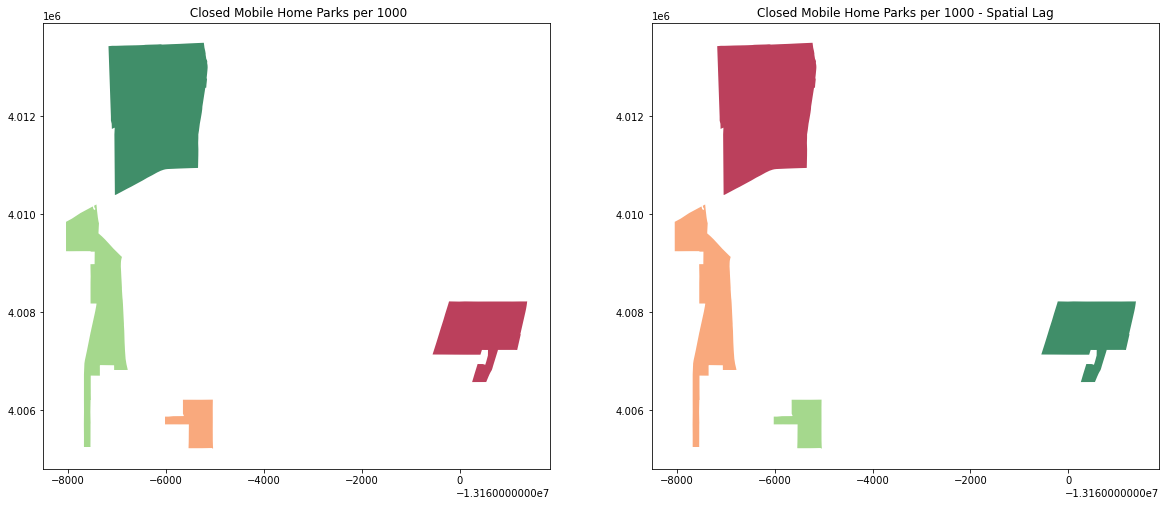

In [346]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

# two subplots produces ax[0] (left) and ax[1] (right)

# regular count map on the left
mhp_carson.plot(ax=ax[0], # this assigns the map to the left subplot
         column='mhp_per_1000', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='black', 
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("on")
ax[0].set_title(" Closed Mobile Home Parks per 1000")

# spatial lag map on the right
mhp_carson.plot(ax=ax[1], # this assigns the map to the right subplot
         column='mhp_per_1000_lag', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='black', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("on")
ax[1].set_title("Closed Mobile Home Parks per 1000 - Spatial Lag")

plt.show()

#### Creating an equivalent map to the ones above, but making it ~interactive~

In [347]:
# interactive version needs to be in WGS84
mhp_carson_web = mhp_carson.to_crs('EPSG:4326')

In [348]:
# what's the centroid?
minx, miny, maxx, maxy = mhp_carson_web.geometry.total_bounds
center_lat_gdf_web = (maxy-miny)/2+miny
center_lon_gdf_web = (maxx-minx)/2+minx

To produce a similar quantile map, I'll need to calculate the values manually, but I don't want to do it manually, so let's put these codes to use! I'll "calculate" my spatial lag column and get the stats I need for my map.

In [349]:
# some stats
mhp_carson_web.mhp_per_1000_lag.describe()

count    4.000000
mean     1.427437
std      0.473801
min      0.733659
25%      1.360977
50%      1.586651
75%      1.653111
max      1.802787
Name: mhp_per_1000_lag, dtype: float64

In [350]:
# grab the median
median = mhp_carson_web.mhp_per_1000_lag.median()

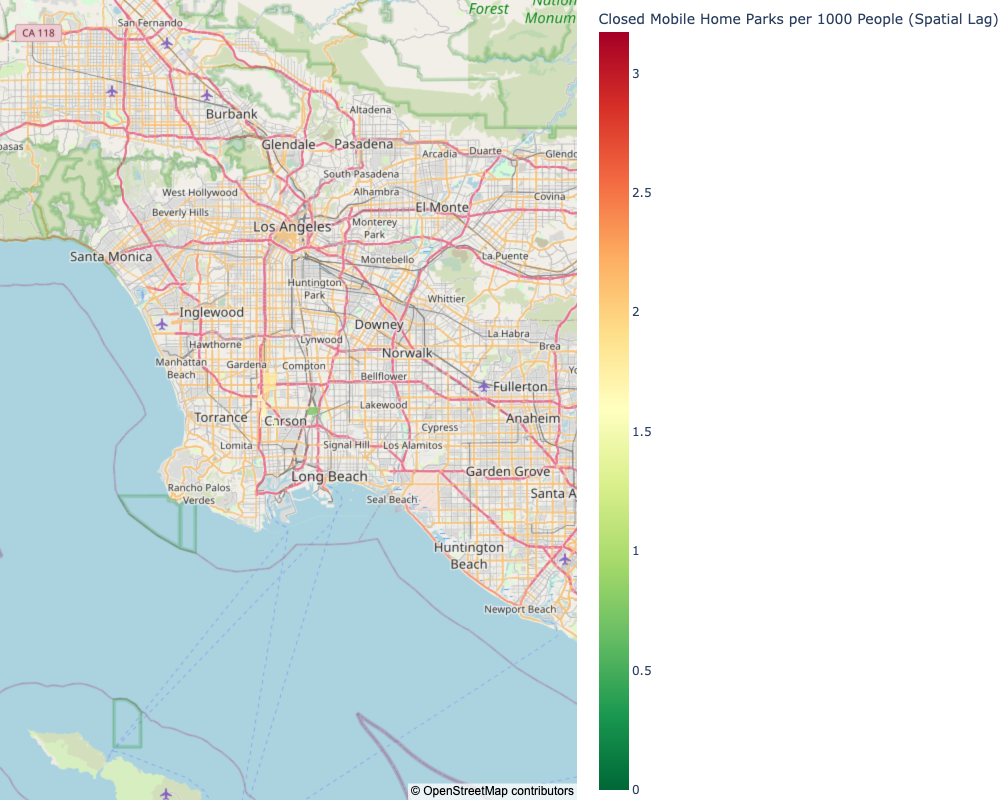

In [351]:
fig = px.choropleth_mapbox(mhp_carson_web, 
                     geojson=mhp_carson_web.geometry, # the geometry column
                     locations=mhp_carson_web.index, # the index
                     mapbox_style="open-street-map",
                     zoom=9, 
                     color='mhp_per_1000_lag',
                     color_continuous_scale='RdYlGn_r',
                     color_continuous_midpoint =median, # put the median as the midpoint
                     range_color =(0,median*2),
                     hover_data=['FIPS','TotalPop','MH SPACES','mhp_per_1000','mhp_per_1000_lag'],
                     center = {"lat": center_lat_gdf_web, "lon": center_lon_gdf_web},
                     opacity=0.8,
                     width=1000,
                     height=800,
                     labels={
                             'mhp_per_1000_lag':'Closed Mobile Home Parks per 1000 People (Spatial Lag)',
                             'arrests_per_1000':'Closed Mobile Home Parks per 1000 People',
                     })
fig.update_traces(marker_line_width=0.1, marker_line_color='white')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

In [352]:
y = mhp_carson.mhp_per_1000
moran = Moran(y, wq)
moran.I

/opt/conda/lib/python3.9/site-packages/esda/moran.py:232: RuntimeWarning:

invalid value encountered in double_scalars

/opt/conda/lib/python3.9/site-packages/esda/moran.py:166: RuntimeWarning:

divide by zero encountered in double_scalars



-0.33333333333333326

This negative value indicates a negative spatial autocorrelation, meaning, the similar values are far from each other and instead the high values are next to low values, low values are next to high values.

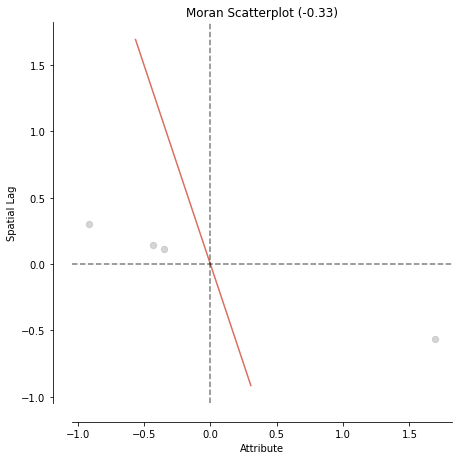

In [353]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: -0.33', ylabel='Density'>)

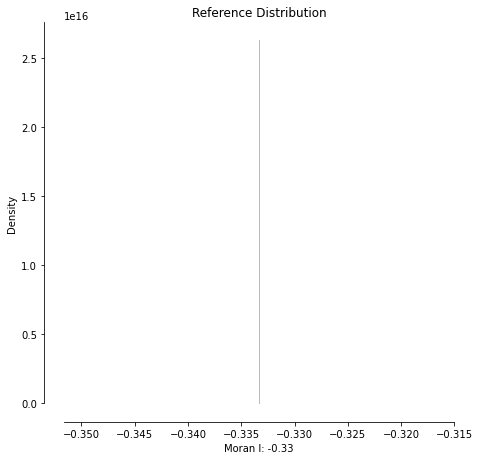

In [354]:
plot_moran_simulation(moran,aspect_equal=False)

In [355]:
moran.p_sim

0.081

Our p-value of 0.08 is greater than our standard p-value of 0.05. This is evidence that there may be a significant difference between mobile home locations and population density.

#### Moran Local Scatterplot - Using Local Indicators of Spatial Association (LISA)

With this scatterplot focusing on the localities in Carson, I want to identify where the clusters are. But we have not detected where clusters are. These are the definitions for my labels: 
HH: High values near to high values
LL: Low values with nearby low values
LH: Low values with high values in its neighborhood
HL: High values with nearby low values in its neighborhood

In [356]:
# calculate local moran values
lisa = esda.moran.Moran_Local(y, wq)

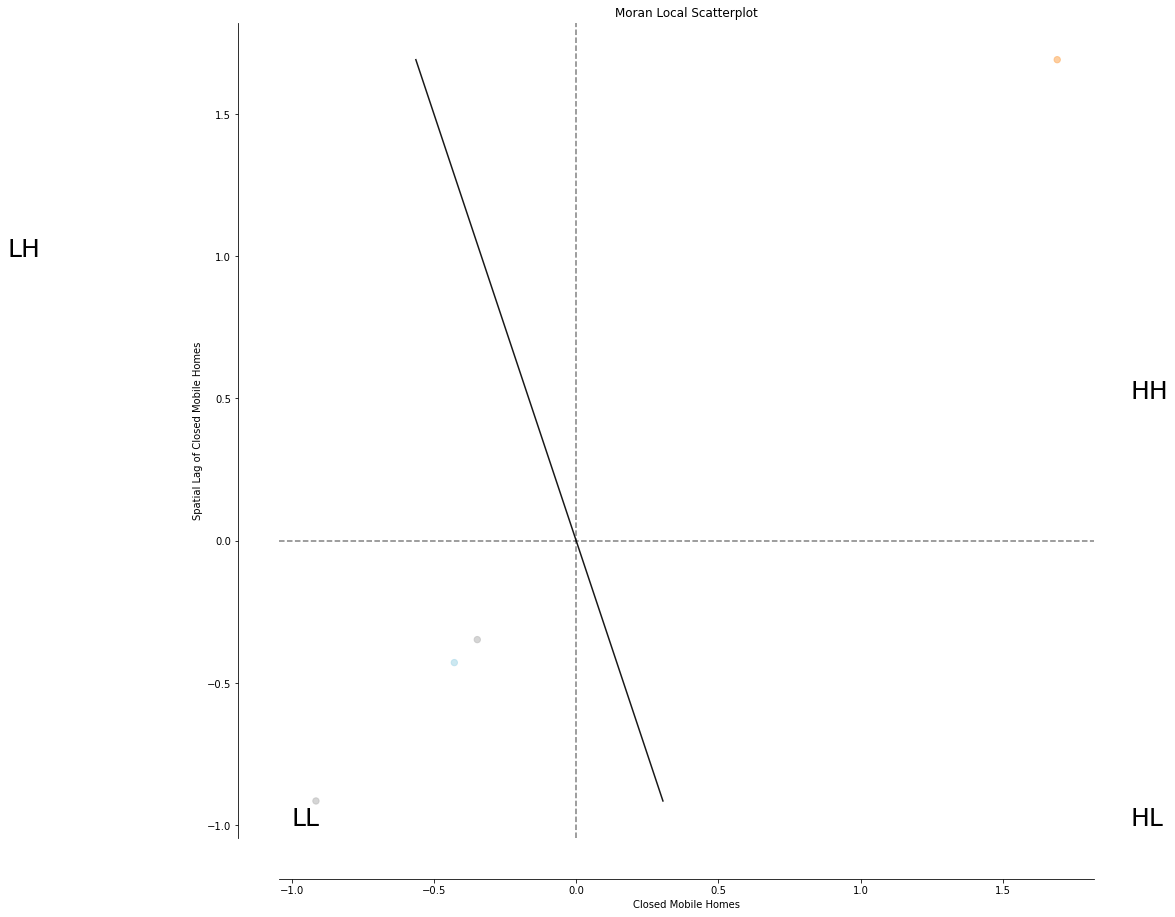

In [357]:
# Plot
fig,ax = plt.subplots(figsize=(20,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Closed Mobile Homes")
ax.set_ylabel('Spatial Lag of Closed Mobile Homes')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

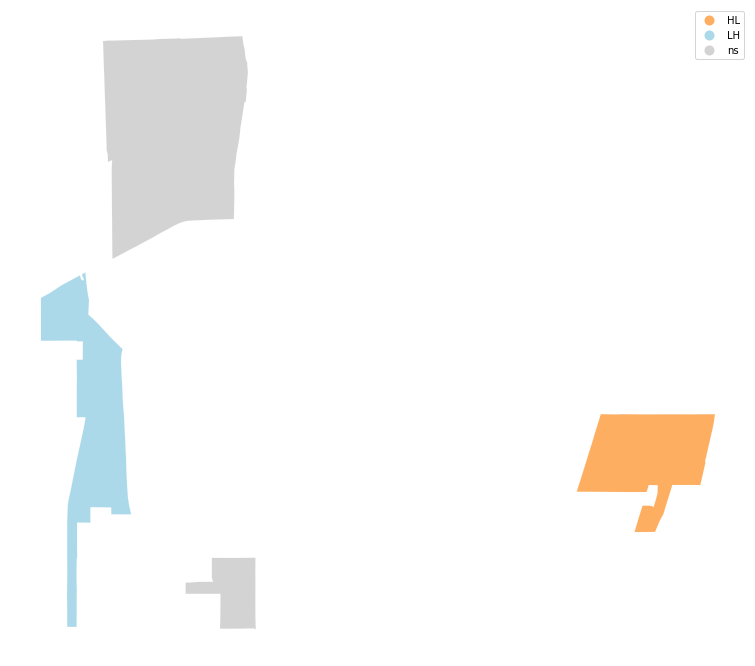

In [358]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, mhp_carson, p=0.05, ax=ax)
plt.show()

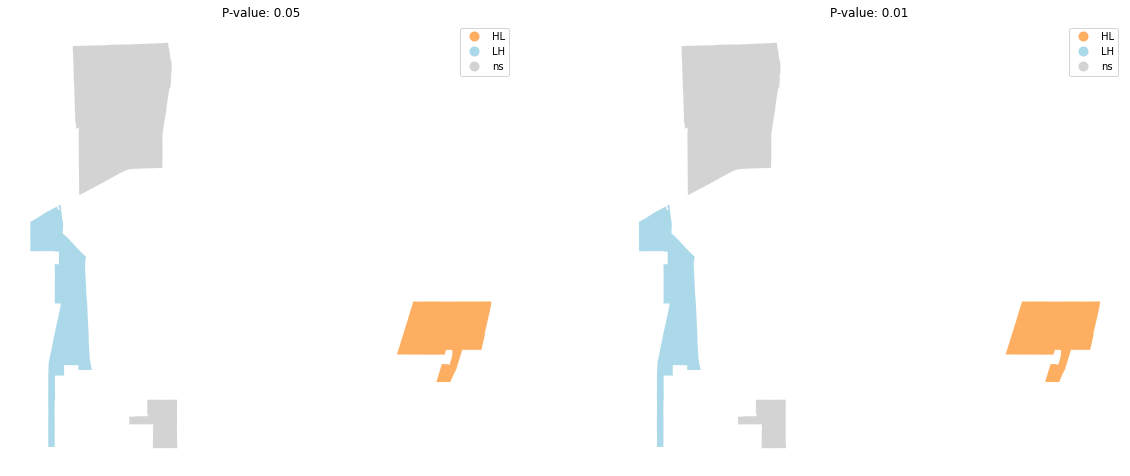

In [359]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

# regular count map on the left
lisa_cluster(lisa, mhp_carson, p=0.05, ax=ax[0])

ax[0].axis("off")
ax[0].set_title("P-value: 0.05")

# spatial lag map on the right
lisa_cluster(lisa, mhp_carson, p=0.01, ax=ax[1])
ax[1].axis("off")
ax[1].set_title("P-value: 0.01")

plt.show()

#### What do we do with this?

Here I see that there are two "clusters" that indicate some significance/patterns between closed mobile home park/mobile home park spaces in Carson. I believe that these plots and maps will be useful in furthering my analysis of demographic information and have given me a better sense on which areas within (and surrounding) Carson may provide more insightful analysis. 